# Cas Kaggle ApC

## Participants

Martí Armengod Villar, 1673911 

Joan Marc Samó Rojas, 1679937 

## Base de dades 
La nostra Base de dades que tracta sobre de dades de partides de escacs aqui tenim el enllaç a la web de Kaggle

https://www.kaggle.com/datasets/datasnaek/chess

Hem escollit aquesta base de dades per que hem vist que predint quin jugador guayara ens ajuda a entendre quin tipus de jugades son mes probables que ens donin la victoria o com d'important es la experencia del jugador o altra informació ue podem extreure.

## Objectius

El que volem ser capaços es predir quin jugador guanyara a partir de la seva llençada inicial.

## Pasos a seguir
0. Feina previa
  * Importar dades
  * Eliminar Duplicats
1. EDA (exploratory data analysis):
  * Atributs
    - Descripció dels atributs:
    - Informació sobre el nostre 'target'
  * Correlació
  * Balancejades
2. Preprocessing:
  * Detecció de Nans
  * Normalització de les dades
  * Eliminar Atributs
  * Matriu de Correlació
    - Correlacions altes
    - Correlacions moderades
    - Altres
  * Gràfic de Dispersió

3. Metric selection:

4. Model Selection amb Crossvalidation:

5. Analisi final


### 0. Feina previa

#### Importar dades
Ara el que farem es importar les nostres dades i fer la separació entre el train i el test per evitar data leakage

In [174]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.svm import SVC
import time

In [89]:
#Funcions Generiques que utilitzarem mes endavant 

#Funció per eliminar atributs
def eliminar_atributs(df, columnes_a_eliminar):
    df_sense_atributs = df.drop(columns=columnes_a_eliminar, axis=1)
    return df_sense_atributs

#Funció per tractar els opening_eco
def encode_opening_eco(code):
    group = code[0]  # Extrae la letra (A, B, C...)
    subgroup = code[1:]  # Extrae los números (YY)
    # Convertir letra a un número (A=1, B=2, ..., Z=26)
    group_num = ord(group) - ord('A') + 1
    # Combinar el grupo y el subgrupo
    encoded_value = int(f"{group_num}{subgroup}")
    return encoded_value
#

In [90]:
# Importar dades del CSV i separar 
dades = pd.read_csv('games.csv')


#### Eliminar Duplicats
També ens hem donat compte que tenim files identiques repetides multiples vegades aixi que avanç de res el que farem es eliminar les repeticons asegurant-nos de eliminar nomes les que son 100% iguals.

In [91]:
# Elimina files duplicades completament iguals

print(f"Dades Abans de treure duplicats: {dades.shape[0]} files")

dades = dades.drop(columns = ["created_at", "last_move_at"])
dades = dades.drop_duplicates()


print()
print(f"Train Després de treure duplicats: {dades.shape[0]} files")


train_set, test_set = train_test_split(dades,random_state=42,test_size=0.2)
train_set

Dades Abans de treure duplicats: 20058 files

Train Després de treure duplicats: 19113 files


,id,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
17712,Q5HSsAlS,True,66,resign,black,8+0,shmulke,1577,bendomo,1596,d4 d5 c4 e6 Nc3 Nf6 Nf3 c5 cxd5 Nxd5 Nxd5 Qxd5...,D41,Queen's Gambit Declined: Semi-Tarrasch | 5.cxd5,9
7693,MDQflvGw,True,96,draw,draw,10+0,bocadagod,1531,ujjaldidarsingh,1430,d4 c5 dxc5 Qa5+ c3 Qxc5 Nf3 Nf6 e3 e5 Nbd2 Be7...,A43,Benoni Defense: Benoni Gambit Accepted,3
8120,87EiAT1b,False,98,mate,black,20+3,joelitrox1234,1500,lichessfiend,1723,d4 c5 c3 cxd4 cxd4 Nf6 Nf3 g6 Bd2 Bg7 e3 O-O B...,A43,Old Benoni Defense,2
17203,UxmNSiyE,True,72,mate,black,20+5,fazouane,1365,lio83390,1442,b3 e5 Nf3 Nc6 d4 Qf6 e3 Bb4+ c3 Ba5 g3 d5 Ba3 ...,A01,Nimzo-Larsen Attack: Modern Variation,2
17827,p0btVtj4,True,28,resign,black,10+0,element4life,1328,danya068,1300,e4 e6 Nf3 d5 Nc3 f5 exf5 d4 Ne4 exf5 Neg5 Nh6 ...,C00,French Defense: Two Knights Variation,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11404,bGiGLLkt,True,104,mate,black,7+2,deno01,1389,taranga,1307,e4 e5 f3 Nf6 Nc3 Bb4 a3 Bc5 Nge2 O-O d4 exd4 N...,C20,King's Pawn Game: King's Head Opening,5
12117,1W7FWOD1,True,121,mate,white,10+0,noobdude,1632,mat43,1692,e4 b6 d4 Bb7 Bd3 g6 Nf3 Bg7 d5 h6 c4 e6 Nc3 ex...,B00,Owen Defense,2
5406,VjoCeF7u,True,45,draw,draw,10+0,cemki22,1530,artem555,1635,e4 c6 d4 d5 exd5 cxd5 Bd3 Nc6 Be3 Nf6 Nf3 Qb6 ...,B13,Caro-Kann Defense: Exchange Variation,5
860,WHRdaJm2,True,52,resign,black,10+5,ducksandcats,1851,wall-of-shields,1679,e4 d6 d4 f5 Bd3 fxe4 Bxe4 e6 Qh5+ Ke7 Nf3 Nf6 ...,B07,Rat Defense: Balogh Defense,4


### 1. EDA (exploratory data analysis):

Una vegada em tingut el data set a les nostres mans hem estat analitzant quines caracteristiques i atributs tenim per poder veure quin son mes utils i necesaris i quins no.

#### Atributs
La nostre base de dades te 16 atributs (columnes)

Són dels tipus següents:
- **Binaris:** Rated
- **Categòric:** Id, Created_at, Last_move_at, Victory_status, Winner, Increment_code, White_id, Black_id, Moves, Opening_eco, Opening_name
- **Numèrics:** Turns, White_rating, Black_rating, Opening_ply

##### Descripció dels atributs:
- **Id:** Identificador de la partida.
- **Rated:** Qualificació de la partida.
- **Created_at:** Hora de començament.
- **Last_move_at:** Hora de fi.
- **Turns:** Numero de torns que ha durat la partida.
- **Victory_status:** Com ha quedat l'estat de la partida (mate,resign,draw).
- **Winner:** Color guanyador (Será el nostre target).
- **Increment_code:** Temps maxim de la partida.
- **White_id:** Identificador del jugador que fara servir les fitxes blanques.
- **White_rating:** Puntuació que té el jugador que utilitza les blanques.
- **Black_id:** Identificador del jugador que fara servir les fitxes negres.
- **Black_rating:** Puntuació que té el jugador que utilitza les negres.
- **Moves:** Movimnets que es relalitzen durant la partida.
- **Opening_eco:** Primer moviment d'obertura.
- **Opening_name:** Nom de la jugada inicial.
- **Opening_ply:** Numero de moviments per realitzar l'obertura.

##### Informació sobre el nostre 'target'

És l'atribut Winner que es del tipus Categoric ja que tenim tres possibles opcions, que serien White, Black o Draw (Empat).

També hem de comentar que la nostra base de dades no conté nans.


In [92]:
tipus_atributs = train_set.info()
print(tipus_atributs)


<class 'pandas.core.frame.DataFrame'>
Index: 15290 entries, 17712 to 16499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15290 non-null  object
 1   rated           15290 non-null  bool  
 2   turns           15290 non-null  int64 
 3   victory_status  15290 non-null  object
 4   winner          15290 non-null  object
 5   increment_code  15290 non-null  object
 6   white_id        15290 non-null  object
 7   white_rating    15290 non-null  int64 
 8   black_id        15290 non-null  object
 9   black_rating    15290 non-null  int64 
 10  moves           15290 non-null  object
 11  opening_eco     15290 non-null  object
 12  opening_name    15290 non-null  object
 13  opening_ply     15290 non-null  int64 
dtypes: bool(1), int64(4), object(9)
memory usage: 1.6+ MB
None


#### Correlació
Hem pogut observat que tenim alguna correlació entre atributs,

- Els atributs de opening_eco, opening_name i opening_ply estan molt relacionats, ja que depenen del tipus de moviment inicial que realitzi sera un nom de obertura amb uns moviments definits. La correlació sera molt més alta entre el opening_name i el opening_ply ja que per cada tipus de obertura te un numero predefinit de moviments inicials ja que si fos diferent ja seria una altre obertura.

Si mirem exactament correlacións entre la X i y podem observar el següent,
- Que sense arreglar una mica les dades es imposible de veuren directament.

#### Balancejades
Observem els seguents desbalancetjos en les següents dades:
- Tenim un 84 % de dades de partides correctes i un 16% de partides incorrectes.
- Tenim un 56% de resign i un 32% de mate en estats de victoria
- Tenim un 50% de vegades en les que ha guanyat el jugador de les fitxes blanques i un 45% que ha guanyat el jugador amb les fitxes negres.

**Conclusió:** 

El desbalanceig en les etiquetes pot provocar un rendiment deficient en la classe minoritària, fent que el model prefereixi la classe majoritària i augmenti la taxa de falsos negatius. Això pot resultar en mètriques enganyoses.

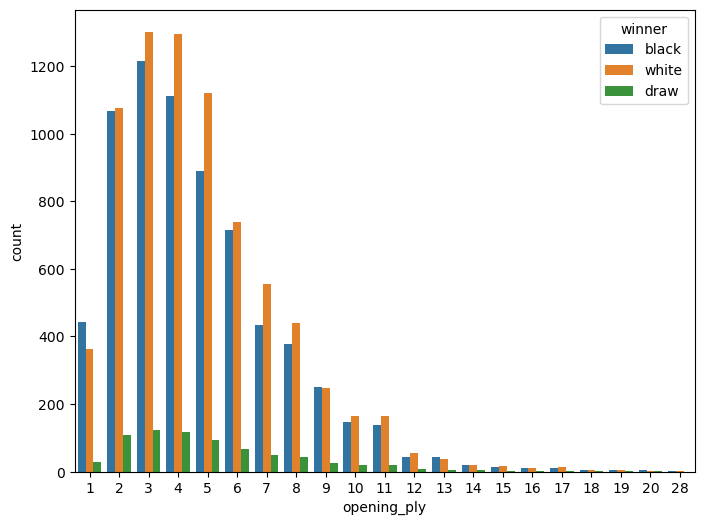

In [93]:
sns.countplot(data=train_set, x='opening_ply', hue='winner')
plt.show()

### 2. Preprocessing:
Ara un cop que ja hem observat les dades amb les que tenim que tractar começarem mirant Si tenim nans, analitzant si s'han de normalitzar atributs, i decidint amb quins atributs ens hauriem de quedar.

#### Detecció de Nans
Hem volgut assegurar-nos de si les nostres dades tenien o no Nans i tal i com haviem observat en la web del Kaggle no en tenim. Ho podem observar en la següent funcio de comprovacio de Nans, Cap columna te cap Nan.

In [94]:
nans = dades.isna().sum()

print(nans)

id                0
rated             0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64


#### Normalització de les dades
Ara el que fem és analitzar els atribuits que tenim i quins creiem que s'haurien d'eliminar i els que ens quedem si els hem de normalitzar com ho fariem.


- **Victory_status**
    - **Tipus de Codificació**: Label Encoding
    - El farem es pasar l'estat de ña partida que en son 4 (resign,draw,mate,outoftime) per numeros per poder-los tractar molt millor.
- **Increment_code**
    - **Tipus de Codificació**: Label Encoding
    - Aqui l'unic que farem és retallar la part final del numero que esta darrera de + ja que compte els temps extres que no ens interesa.
- **White_rating**
    - **Tipus de Codificació**: Label Encoding
    - Podem resumir els punts en 6 categories que dependra del valor de puntuació  apartir de 1100 anirem pujant la categoria creant del 1 al 6 per tal de saber el nivell del jugador.
- **Black_rating**
    - **Tipus de Codificació**: Label Encoding
    - Podem resumir els punts en 6 categories que dependra del valor de puntuació  apartir de 1100 anirem pujant la categoria creant del 1 al 6 per tal de saber el nivell del jugador.



In [95]:
from sklearn.calibration import LabelEncoder

#PREPROCESSING

train_set['victory_status'] = LabelEncoder().fit_transform(train_set['victory_status'])
test_set['victory_status'] = LabelEncoder().fit_transform(test_set['victory_status'])


train_set['increment_code'] = train_set['increment_code'].str.split('+').str[0]
test_set['increment_code'] = test_set['increment_code'].str.split('+').str[0]

#---------------------------------------------------------------------------------------------------------------------------------------------------------
# Definir intervals i etiquetes
bins = [0, 1100, 1600, 2000, 2300, 3000, float('inf')]
labels = [1, 2, 3, 4, 5, 6]

# Aplicar a 'white_rating' i 'black_rating'
train_set['white_level'] = pd.cut(train_set['white_rating'], bins=bins, labels=labels, right=False).astype(int)
train_set['black_level'] = pd.cut(train_set['black_rating'], bins=bins, labels=labels, right=False).astype(int)

test_set['white_level'] = pd.cut(test_set['white_rating'], bins=bins, labels=labels, right=False).astype(int)
test_set['black_level'] = pd.cut(test_set['black_rating'], bins=bins, labels=labels, right=False).astype(int)

# Verificar distribucions
print(train_set['white_level'].value_counts())
print(train_set['black_level'].value_counts())

#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Crear un LabelEncoder
label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna 'winner'
train_set['winner_numeric'] = label_encoder.fit_transform(train_set['winner'])

# Veure el mapping de valors
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Per fer el mateix amb el conjunt de test:
test_set['winner_numeric'] = label_encoder.transform(test_set['winner'])

#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Aplicar label encoding a la cimuna opening_eco
train_set['opening_eco'] = train_set['opening_eco'].apply(encode_opening_eco)
test_set['opening_eco'] = test_set['opening_eco'].apply(encode_opening_eco)


#---------------------------------------------------------------------------------------------------------------------------------------------------------

train_set

white_level
2    7745
3    5647
4    1220
1     510
5     168
Name: count, dtype: int64
black_level
2    7781
3    5552
4    1240
1     576
5     141
Name: count, dtype: int64
{'black': 0, 'draw': 1, 'white': 2}


,id,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,white_level,black_level,winner_numeric
17712,Q5HSsAlS,True,66,3,black,8,shmulke,1577,bendomo,1596,d4 d5 c4 e6 Nc3 Nf6 Nf3 c5 cxd5 Nxd5 Nxd5 Qxd5...,441,Queen's Gambit Declined: Semi-Tarrasch | 5.cxd5,9,2,2,0
7693,MDQflvGw,True,96,0,draw,10,bocadagod,1531,ujjaldidarsingh,1430,d4 c5 dxc5 Qa5+ c3 Qxc5 Nf3 Nf6 e3 e5 Nbd2 Be7...,143,Benoni Defense: Benoni Gambit Accepted,3,2,2,1
8120,87EiAT1b,False,98,1,black,20,joelitrox1234,1500,lichessfiend,1723,d4 c5 c3 cxd4 cxd4 Nf6 Nf3 g6 Bd2 Bg7 e3 O-O B...,143,Old Benoni Defense,2,2,3,0
17203,UxmNSiyE,True,72,1,black,20,fazouane,1365,lio83390,1442,b3 e5 Nf3 Nc6 d4 Qf6 e3 Bb4+ c3 Ba5 g3 d5 Ba3 ...,101,Nimzo-Larsen Attack: Modern Variation,2,2,2,0
17827,p0btVtj4,True,28,3,black,10,element4life,1328,danya068,1300,e4 e6 Nf3 d5 Nc3 f5 exf5 d4 Ne4 exf5 Neg5 Nh6 ...,300,French Defense: Two Knights Variation,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11404,bGiGLLkt,True,104,1,black,7,deno01,1389,taranga,1307,e4 e5 f3 Nf6 Nc3 Bb4 a3 Bc5 Nge2 O-O d4 exd4 N...,320,King's Pawn Game: King's Head Opening,5,2,2,0
12117,1W7FWOD1,True,121,1,white,10,noobdude,1632,mat43,1692,e4 b6 d4 Bb7 Bd3 g6 Nf3 Bg7 d5 h6 c4 e6 Nc3 ex...,200,Owen Defense,2,3,3,2
5406,VjoCeF7u,True,45,0,draw,10,cemki22,1530,artem555,1635,e4 c6 d4 d5 exd5 cxd5 Bd3 Nc6 Be3 Nf6 Nf3 Qb6 ...,213,Caro-Kann Defense: Exchange Variation,5,2,3,1
860,WHRdaJm2,True,52,3,black,10,ducksandcats,1851,wall-of-shields,1679,e4 d6 d4 f5 Bd3 fxe4 Bxe4 e6 Qh5+ Ke7 Nf3 Nf6 ...,207,Rat Defense: Balogh Defense,4,3,3,0


#### Eliminar Atributs
Hem de tenir en compte que tenim columnes com per exemple la id de la partida que no ens aporta cap dada rellevant ja que es unica per cada partida i no podriem obtenir informació d'ella.

Ara el farem es veure quines columnes són les que necesitem per poder predir el que volem saber que és qui guanyara segons els primers moviments.
- **Id**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que es el identificador de partida.
- **Created_at**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que es l'hora de començament.
- **Last_move_ad**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que es l'hora de finalització.
- **White_id**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que és l'identificador del jugador que fara servir les fitxes blanques.
- **Black_id**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que és l'identificador del jugador que fara servir les fitxes negres.   
- **Move**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que són tots els movimnets que es relalitzen durant la partida i són practicament unics.
- **Opening_name**
    - **Decisió**: Eliminar
    - Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que són els noms de les jugades inicials.




In [96]:
train_set = eliminar_atributs(train_set,["id","white_id","black_id","white_id","moves","opening_name", "winner"])
train_set

,rated,turns,victory_status,increment_code,white_rating,black_rating,opening_eco,opening_ply,white_level,black_level,winner_numeric
17712,True,66,3,8,1577,1596,441,9,2,2,0
7693,True,96,0,10,1531,1430,143,3,2,2,1
8120,False,98,1,20,1500,1723,143,2,2,3,0
17203,True,72,1,20,1365,1442,101,2,2,2,0
17827,True,28,3,10,1328,1300,300,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
11404,True,104,1,7,1389,1307,320,5,2,2,0
12117,True,121,1,10,1632,1692,200,2,3,3,2
5406,True,45,0,10,1530,1635,213,5,2,3,1
860,True,52,3,10,1851,1679,207,4,3,3,0


In [97]:
test_set = eliminar_atributs(test_set,["id","white_id","black_id","white_id","moves","opening_name", "winner"])
test_set

,rated,turns,victory_status,increment_code,white_rating,black_rating,opening_eco,opening_ply,white_level,black_level,winner_numeric
6562,True,34,1,15,1434,1265,350,8,2,2,0
9402,True,44,3,20,1600,1175,302,7,3,2,2
15954,True,71,3,15,1780,1686,350,9,3,3,2
6499,True,48,1,20,1449,1551,346,7,2,2,0
4261,True,51,1,10,2023,1168,120,2,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
12602,True,105,2,10,1567,1522,341,4,2,2,2
16111,True,42,3,10,1684,1631,130,2,3,3,0
4274,True,38,0,15,1420,1239,350,5,2,2,1
2072,True,84,3,5,1354,1423,321,3,2,2,0


#### Matriu de Correlació

1. **Correlacions altes**:
   - Es pot observar clarament que white_rating i black_rating tenen una correlació positiva forta amb els respectius nivells (white_level i black_level). És logic que augmentin les puntuacions dels jugadors a mesura que també ho fa el seu nivell.
   - Una altra correlació interessant és entre opening_eco i opening_ply, que reflecteix la relació entre el tipus d'obertura i el nombre de moviments involucrats, cosa que té sentit en el context d'estratègies d'escacs.

2. **Correlacions moderades**:
   - La relació entre victory_status i turns pot tenir explicacions variables. Partides més llargues tendeixen a acabar en empat o fora de temps, però també destaca que jugadors de nivells molt alts acaben les partides més ràpidament.

3. **Altres**:
   - Aquesta matriu no només ens mostra patrons evidents, sinó també llocs on la correlació no és tan forta com per exemple, entre rated i altres variables, que ens pot indicar que el fet de ser una partida classificada o no classificada té menys influència en els resultats.

<Axes: >

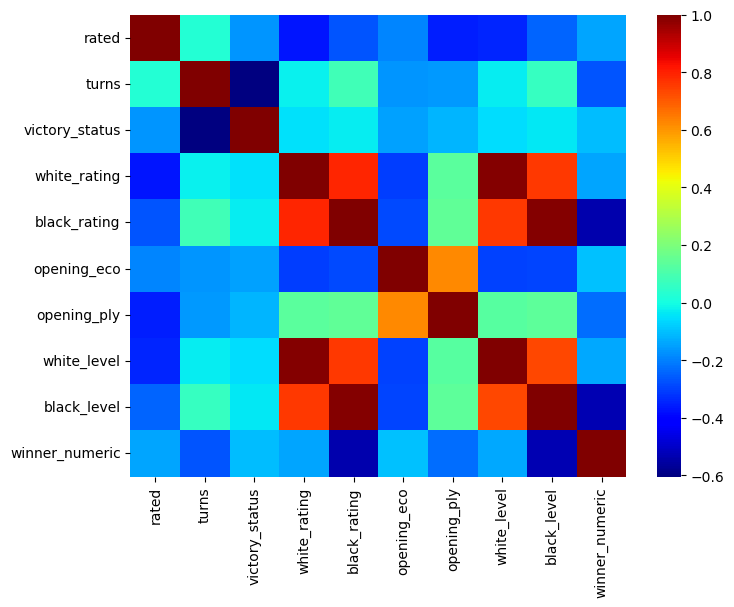

In [98]:
corr = train_set.corr(numeric_only=True) # take only numeric columns 
sns.heatmap(corr.corr(), annot=False, cmap='jet') # heatmap with numerical columns

#### Gràfic de Dispersió

El gràfic de dispersió entre el **white_rating** i el **black_rating** mostra una clara correlació positiva tal i com hem observat en la matriu de correlació d'abans i també ens indica que les partides normalment fa que s'enfrontin jugadors amb nivells similars. 

Podem observar una concentració de dades en el rang de entre 1200 i 1800 punts per tots dos jugadors. Que vol dir que la major part de les partides és juguen entre jugadors amateurs o de nivell mitjà.

La relació entre les puntuacions dels jugadors pot ser un atribut important a tenir en compte per el model de predicció, ja que la diferència entre les puntuacions (white_rating - black_rating) podria ser un factor important per predir el guanyador de la partida o si aquesta acabarà en empat.

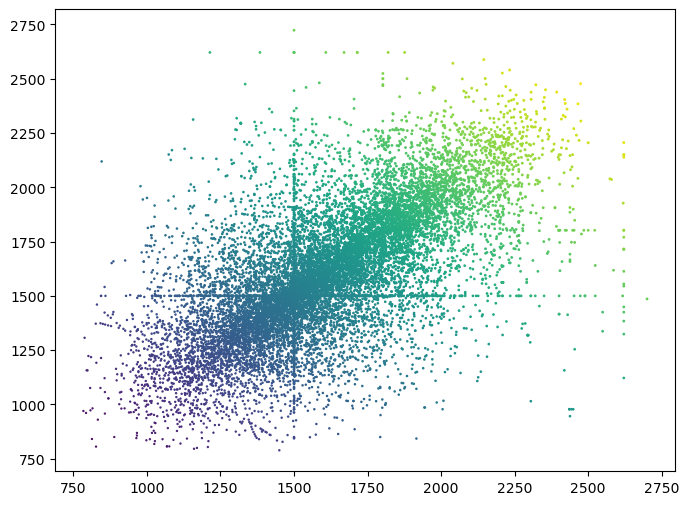

In [99]:
black_rating= train_set["black_rating"]
white_rating=  train_set["white_rating"]

plt.scatter(white_rating,black_rating,s=((black_rating+white_rating)//2)*0.0005,c=((black_rating+white_rating)//2)*0.0005) 
plt.rcParams["figure.figsize"] = (8,6) # execute this cell 2 times because it is not updating in first time

### Metric selection:

Les millors metriques en aquest cas son les següents:

- Precission: volem saber si una apertura guanyadora ho es amb certessa, no ens interessa tenir un gran nombre d'opcions igulment valides sinó tenir clar quines ho són realment.

- Accuracy 



In [100]:
def plot_roc_curve_mc(y_true, y_pred_prob):
    classes = np.unique(y_true)
    
    plt.figure()

    for c in classes:
        y_true_c = y_true == c

        fpr, tpr, thresholds = roc_curve(y_true_c, y_pred_prob[:,c])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='ROC curve ' + str(c) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve_mc(y_true, y_pred_prob):
    classes = np.unique(y_true)
    
    plt.figure()

    for c in classes:
        y_true_c = (y_true == c).astype(int)

        precision, recall, thresholds = precision_recall_curve(y_true_c, y_pred_prob[:,c])
        average_precision = auc(recall, precision)

        plt.plot(recall, precision, lw=2, label='Precision-Recall curve ' + str(c) + ' (area = %0.2f)' % average_precision)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

def evaluate_prediction(y_test, y_pred_prob):
    #transformem probabilitat en certesa
    y_pred = np.argmax(y_pred_prob, axis=1)

    #Mostrem matriu de confusio
    print(confusion_matrix(y_test, y_pred))
    
    #Mostrem dades generals
    print(classification_report(y_test, y_pred))

    #mostrem cuves roc i pr
    plot_roc_curve_mc(y_test, y_pred_prob)
    plot_precision_recall_curve_mc(y_test, y_pred_prob)

def evaluate_model(model, X_train, y_train):
    #fem crossvalidation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    print(mean_score)
    
test_set

,rated,turns,victory_status,increment_code,white_rating,black_rating,opening_eco,opening_ply,white_level,black_level,winner_numeric
6562,True,34,1,15,1434,1265,350,8,2,2,0
9402,True,44,3,20,1600,1175,302,7,3,2,2
15954,True,71,3,15,1780,1686,350,9,3,3,2
6499,True,48,1,20,1449,1551,346,7,2,2,0
4261,True,51,1,10,2023,1168,120,2,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
12602,True,105,2,10,1567,1522,341,4,2,2,2
16111,True,42,3,10,1684,1631,130,2,3,3,0
4274,True,38,0,15,1420,1239,350,5,2,2,1
2072,True,84,3,5,1354,1423,321,3,2,2,0


### Model Selection amb Crossvalidation:



In [101]:
y_train = train_set['winner_numeric']
X_train = train_set.drop(columns=['winner_numeric'])
y_test = test_set['winner_numeric']
X_test = test_set.drop(columns=['winner_numeric'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

lr_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

rf_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

knn_grid = {
    'n_neighbors': [2, 5, 7, 10, 15, 22, 30],
    'weights': ['uniform', 'distance']
}

svm_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

lr = LogisticRegression(max_iter=1000, tol=1e-3)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True, max_iter=10000)



In [102]:
def find_hiperparam(model, param_grid, XX_train, yy_train):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted')
    grid_search.fit(XX_train, yy_train)
    return grid_search.best_params_


lr_param = find_hiperparam(lr, lr_grid, X_train, y_train)
rf_param = find_hiperparam(rf, rf_grid, X_train, y_train)
rf_param = find_hiperparam(knn, knn_grid, X_train, y_train)
find_hiperparam(svm, svm_grid, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
def find_hiperparam_grid(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X,y)
    return grid_search.best_params_



#lr_param = find_hiperparam_grid(lr, lr_grid, X_train, y_train)
#print(lr_param)

#rf_param = find_hiperparam_grid(rf, rf_grid, X_train, y_train)
#print(rf_param)

#knn_param = find_hiperparam_grid(knn, knn_grid, X_train, y_train)
#print(knn_param)

svm_param = find_hiperparam_grid(svm, svm_grid, X_train, y_train)
print(svm_param)

{'C': 0.01, 'kernel': 'linear'}


0.6700455544710578
[[ 795    0  581]
 [   2  144    1]
 [ 440    0 1095]]
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1376
           1       1.00      0.98      0.99       147
           2       0.65      0.71      0.68      1535

    accuracy                           0.67      3058
   macro avg       0.77      0.76      0.76      3058
weighted avg       0.67      0.67      0.66      3058



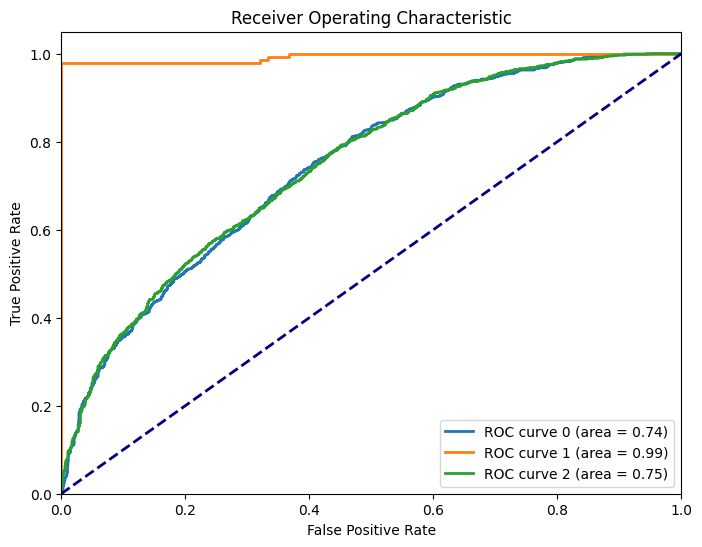

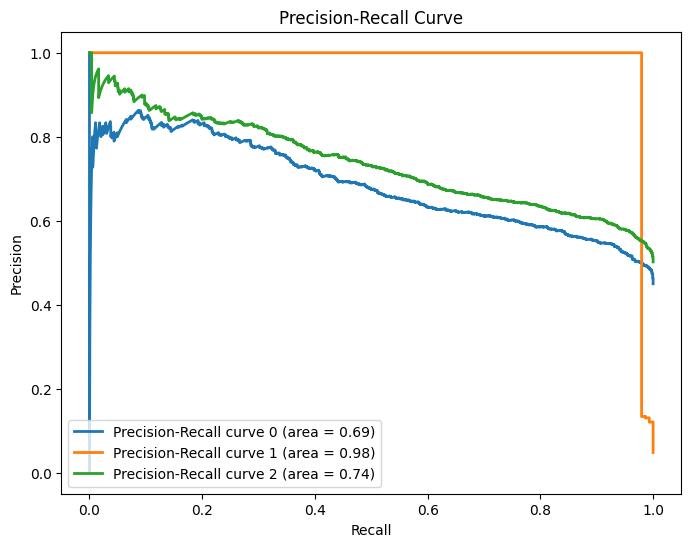

0.6639138618516307
[[ 845    0  531]
 [   0  144    3]
 [ 502    0 1033]]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1376
           1       1.00      0.98      0.99       147
           2       0.66      0.67      0.67      1535

    accuracy                           0.66      3058
   macro avg       0.76      0.76      0.76      3058
weighted avg       0.66      0.66      0.66      3058



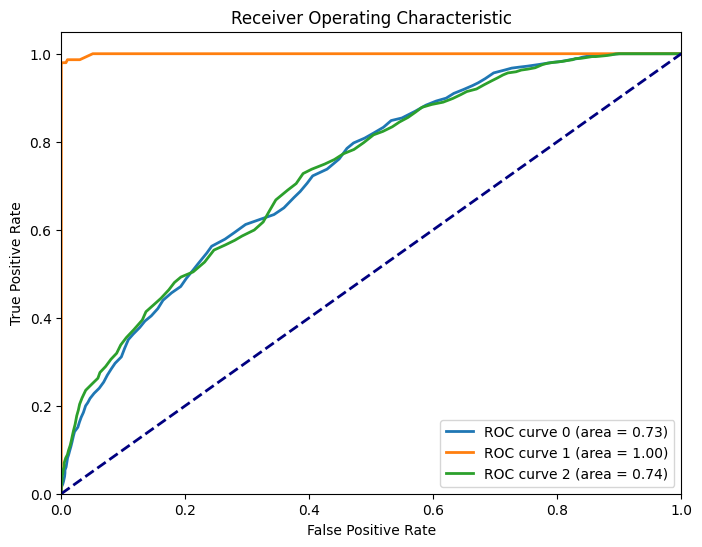

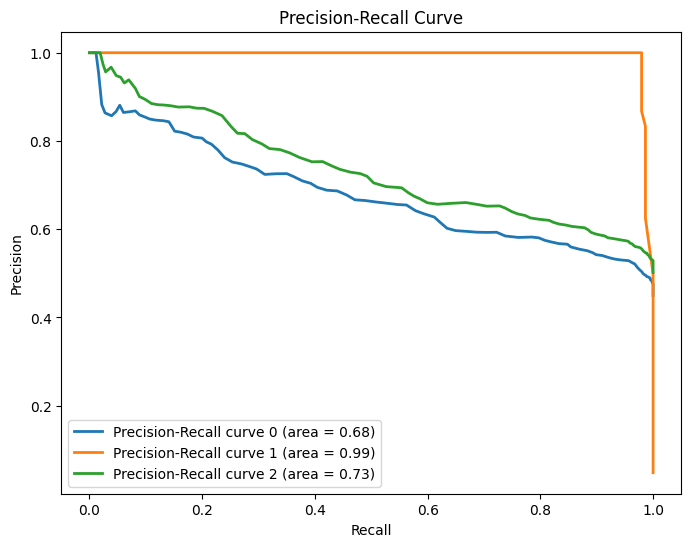

0.6110199516754375
[[798   0 578]
 [ 23 111  13]
 [565   1 969]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1376
           1       0.99      0.76      0.86       147
           2       0.62      0.63      0.63      1535

    accuracy                           0.61      3058
   macro avg       0.73      0.66      0.69      3058
weighted avg       0.62      0.61      0.62      3058



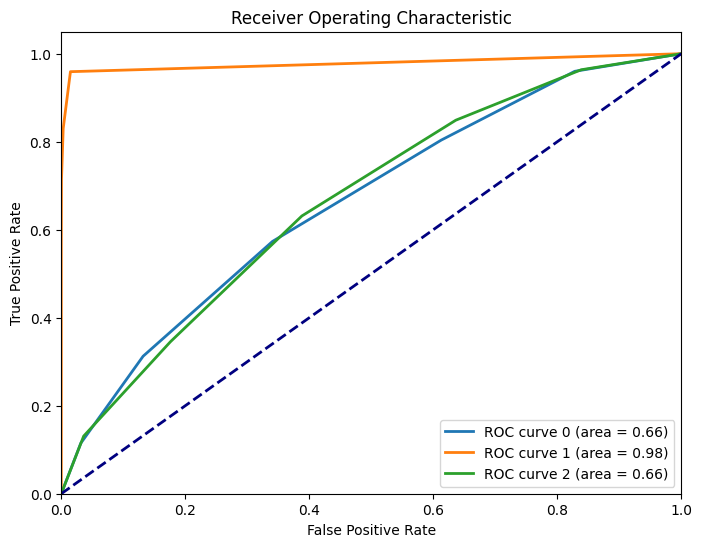

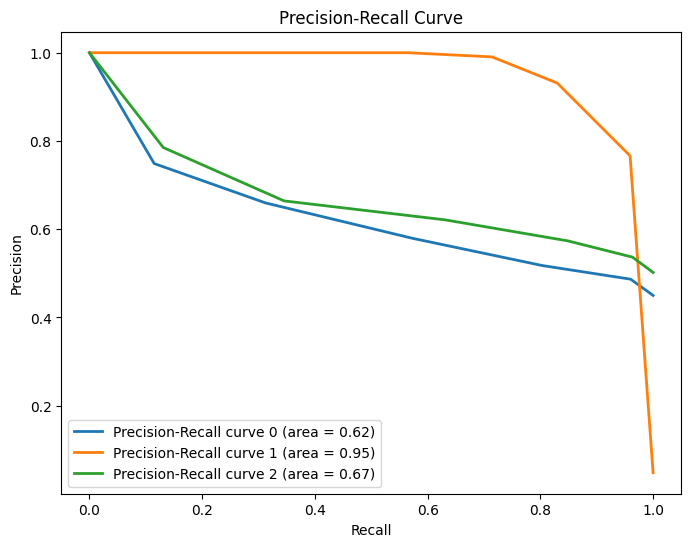

0.6624425723957883
[[ 796    0  580]
 [   4  142    1]
 [ 449    1 1085]]
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1376
           1       0.99      0.97      0.98       147
           2       0.65      0.71      0.68      1535

    accuracy                           0.66      3058
   macro avg       0.76      0.75      0.75      3058
weighted avg       0.66      0.66      0.66      3058



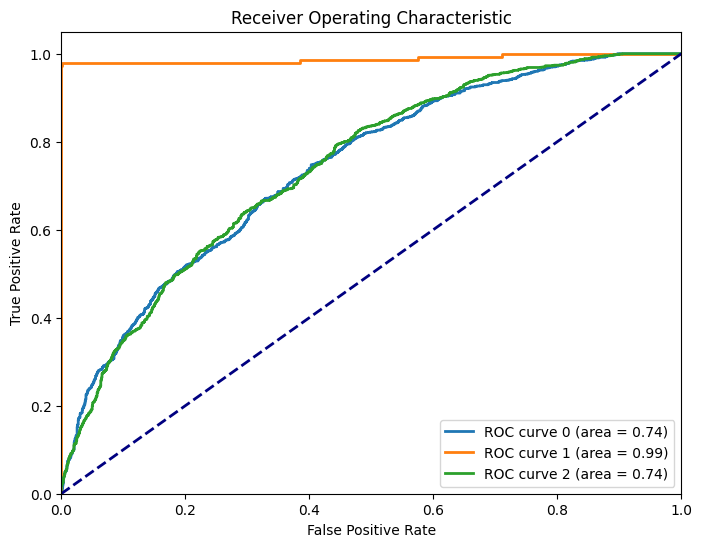

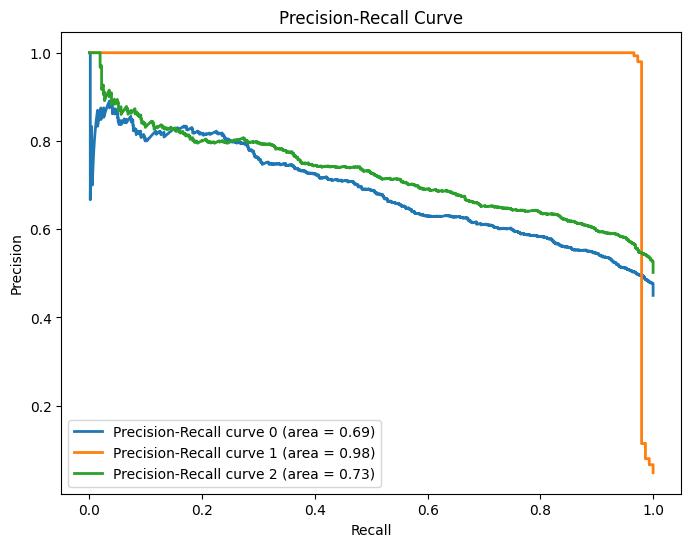

In [150]:
def fit_model(model, param_grid, X_train, y_train, X_test, y_test):
    evaluate_model(model, X_train, y_train)

    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)

    evaluate_prediction(y_test, y_pred_prob)

print("lr")
fit_model(lr, lr_grid, X_train, y_train, X_test, y_test)

print("rf")
fit_model(rf, rf_grid, X_train, y_train, X_test, y_test)

print("knn")
fit_model(knn, knn_grid, X_train, y_train, X_test, y_test)

print("svm")
fit_model(svm, svm_grid, X_train, y_train, X_test, y_test)


### Analisi final

